## Computational Mechanistic Study of an S<sub>N</sub>2 Reaction

The S<sub>N</sub>2 (bimolecular nucleophilic substitution) reaction is a fundamental mechanism in organic chemistry, characterized by a concerted substitution where the nucleophile attacks the electrophilic carbon from the opposite side of the leaving group. This results in inversion of stereochemistry and transition through a single transition state.

In this computational study, the reaction between fluoride anion and methyl chloride:
**<p style="text-align:center;"> F<sup>-</sup> + CH<sub>3</sub>Cl -> Cl<sup>-</sup> + CH<sub>3</sub>F </p>**
in the gas phase is investigated. The process involves: 
- **Geometry optimization** of reactants, products, and transition state (TS)
- **Frequency analysis** to confirm the nature of the stationary points
- **Intrinsic Reaction Coordinate** (IRC) calculation to confirm the connectivity between TS and minima
- **Energy calculations** at different levels of theory

### Tools and Methods

All calculations were carried out using Psi4, an open-source quantum chemistry software package designed for efficient ab initio electronic structure calculations. Psi4 supports a wide range of methods including Hartree–Fock (HF), post-HF (e.g. MP2), and density functional theory (DFT)

The following Python modules were used to support the computational analysis and visualization:
- `psi4`: for quantum chemistry calculations,
- `numpy` and `pandas`: for data processing and analysis,
- `matplotlib`: for plotting energy profiles and data visualization,
- `py3Dmol`: for interactive 3D molecular visualization.

### Methodology

In computational chemistry, it is general practice to:
- Use lower-level methods and smaller basis sets for geometry optimizations to reduce computational cost.
- Perform single-point energy calculations using higher-level methods and larger basis sets on the optimized geometry to achieve more accurate energies.

In this study, the following **model chemistry** is employed:
**<p style="text-align:center;"> MP2/6-31++G(d,p)//HF/6-31+G(d) </p>**
This notation indicates that:
- **Geometry optimization** is performed at the **HF** level, using the **6-31+G(d)** basis set.
- **Single-point energy calculation** is conducted at the **MP2** level, using the **6-31++G(d,p)** basis set.

Basis Set Rationale:
- **6-31+G(d)** (= 6-31+G*): A split-valence basis set with one set of polarization functions (d) and diffuse functions (+) added. The inclusion of diffuse functions is essential for accurately describing anionic species such as F⁻ and Cl⁻.

- **6-31++G(d,p)** (= 6-31++G**): Adds diffuse functions to both hydrogen and heavier atoms (++), and includes polarization functions (d on heavy atoms, p on hydrogen) for improved electron distribution flexibility.


In [2]:
import psi4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import py3Dmol

The memory and CPU threads were set for efficient computation. All output was directed to a dedicated file (output.dat) for logging and further analysis.

In [ ]:
psi4.set_memory('2GB')
psi4.set_num_threads(2)
psi4.core.set_output_file('output.dat', False)


  Memory set to   1.863 GiB by Python driver.
  Threads set to 2 by Python driver.


### Geometry Optimization, Frequency Calculation, and Energy Evaluation

Reactant and product molecules are defined using internal coordinates (Z-matrix) with neutral charge and singlet spin multiplicity (0 1).

In [4]:
CH3Cl = psi4.geometry(""" 
0 1
C
H 1 1.09
H 1 1.09 2 109.5
H 1 1.09 2 109.5 3 120.0
Cl 1 1.78 2 109.5 3 -120.0                                                   
""")

CH3F = psi4.geometry(""" 
0 1
C
H 1 1.09
H 1 1.09 2 109.5
H 1 1.09 2 109.5 3 120.0
F 1 1.38 2 109.5 3 -120.0                                                   
""")

molecules = {'CH3Cl': CH3Cl, 'CH3F': CH3F}

scale_factor = 0.911

For each molecular species, the following steps are performed:
1. Geometry optimization using the Hartree–Fock method with the 6-31+G(d) basis set.
2. Frequency analysis at the same level of theory to:
    - Confirm whether the optimized structure is a minimum (i.e., all vibrational frequencies are real).
    - Compute the zero-point vibrational energy (ZPE).
3. Single-point energy calculation at the MP2/6-31++G(d,p) level to obtain the correlated electronic energy.
4. Zero-point corrected energy  is then calculated as:
$$ E^0 = E_{e} + ZPE_{scaled} $$

Notes on Frequency Calculations:
- Frequency calculations are only valid at stationary points on the potential energy surface (PES), meaning the structure must first be optimized.
- The same method and basis set used for geometry optimization must be used for the frequency job to ensure consistent energy derivatives.
- The results of the frequency calculation can be found under the "Harmonic Vibrational Analysis" section and the ZPE under the "Thermochemistry Energy Analysis" section of the output file. (Here: ZPE is parsed programmatically from the output file)
- Harmonic vibrational frequencies and ZPE values calculated at the HF level systematically overestimate real values due to the neglect of electron correlation. For this reason, it is standard practice to apply an empirical scaling factor. A value of 0.911 is used for HF/6-31+G(d).



In [ ]:
Ee_dict = {}
ZPE_dict = {}
E0_dict = {}

# Function for parsing the ZPE from the frequency job output
def extract_ZPE():
    with open('output.dat', 'r') as f:
        lines = f.read().splitlines()
    for line in lines:
        if 'Correction ZPVE to E_e' in line:
            ZPE = float(line.split()[-4])
    return ZPE

for key, val in molecules.items():
    # Geometry optimization and Frequency job at HF level
    psi4.optimize('HF/6-31+G*', molecule = val)
    psi4.frequency('HF/6-31+G*')

    # ZPE
    ZPE = extract_ZPE()
    ZPE_dict[key] = ZPE

    # Energy calculation at MP2 level
    Ee = psi4.energy('MP2/6-31++G**', molecule = val)
    Ee_dict[key] = Ee

    # Calculate zero-point corrected Energy
    E0 = Ee + ZPE * scale_factor
    E0_dict[key] = E0

    psi4.core.clean()

    print(f'E_e({key}) = {round(Ee, 5)} hartrees')
    print(f'ZPE({key}) = {round(ZPE, 5)} hartrees (unscaled)')
    print(f'E_0({key}) = {round(E0, 5)} hartrees')

Optimizer: Optimization complete!
E_e(CH3Cl) = -499.39681 hartrees
ZPE(CH3Cl) = 0.04177 hartrees (unscaled)
E_0(CH3Cl) = -499.35875 hartrees


	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 5.42e-06



Optimizer: Optimization complete!
E_e(CH3F) = -139.38428 hartrees
ZPE(CH3F) = 0.04234 hartrees (unscaled)
E_0(CH3F) = -139.34571 hartrees


In [6]:
CH3Cl.print_in_input_format()
CH3F.print_in_input_format()

For atomic anions (Cl</sup>⁻</sup> and F</sup>⁻</sup>), only single-point energy calculations are performed using MP2/6-31++G(d,p), as these species consist of a single atom and have no molecular geometry or vibrational modes.

In [7]:
Cl_ion = psi4.geometry(""" 
-1 1
Cl
""")

F_ion = psi4.geometry(""" 
-1 1
F
""")

ions = {'Cl-': Cl_ion, 'F-': F_ion}

for key, val in ions.items():
    Ee = psi4.energy('MP2/6-31++G**', molecule = val)
    Ee_dict[key] = Ee

    psi4.core.clean()

    print(f'E_e({key}) = {round(Ee, 5)} hartrees')

E_e(Cl-) = -459.68151 hartrees
E_e(F-) = -99.62606 hartrees


The following table summarizes the electronic energies ($E_e$), zero-point vibrational energies ($ZPE$, unscaled), and ZPE-corrected energies ($E^0$) of the reactants and products involved in the S<sub>N</sub>2 reaction:

In [8]:
system = ['Cl-', 'F-', 'CH3Cl', 'CH3F']
Ee_list = [Ee_dict['Cl-'], Ee_dict['F-'], Ee_dict['CH3Cl'], Ee_dict['CH3F']]
ZPE_list = ['0.0', '0,0', ZPE_dict['CH3Cl'], ZPE_dict['CH3F']]
E0_list = ['-', '-', E0_dict['CH3Cl'], E0_dict['CH3F']]

dict = {'System': system, 'E_e (Eh)': Ee_list, 'ZPE (Eh) *unscaled': ZPE_list, 'E^0 (Eh)': E0_list}
df = pd.DataFrame(dict)

df

,System,E_e (Eh),ZPE (Eh) *unscaled,E^0 (Eh)
0,Cl-,-459.681511,0.0,-
1,F-,-99.626056,"0,0",-
2,CH3Cl,-499.396809,0.041772,-499.358755
3,CH3F,-139.384283,0.042342,-139.345709


### Optimization of Transition Structure

The geometry of the transition state (TS) for the S<sub>N</sub>2 reaction is optimized using HF theory with the 6-31+G(d) basis set. The optimization is performed using the `'opt_type': 'ts'` option, which directs Psi4 to locate a first-order saddle point (i.e., a structure with exactly one imaginary frequency).The `'full_hess_every': 0` option instructs Psi4 to compute the full Hessian matrix only at the first optimization step. This is typical for TS optimizations, as a full Hessian helps identify the nature of the stationary point early in the optimization process.

Initial Geometry Considerations:
- The reacting complex has an overall charge of –1
- Initial bond distances of C–F and C–Cl are set as the sum of the respective covalent radii plus 0.5 Å
- The F–C–H angle is set to 89.9° instead of an exact 90° to allow for asymmetry; the angle is expected to bend slightly more towards F due to its smaller atomic radius.
- The Cl atom is placed linearly opposite F along the Cl–C–F axis.

In [9]:
ts = psi4.geometry(""" 
-1 1
F                   
C 1 1.83
H 2 1.09 1 89.9
H 2 1.09 1 89.9 3 120.0
H 2 1.09 1 89.9 3 -120.0                                      
Cl 2 2.28 1 180.0 3 0.0  
symmetry c1                 
""")

psi4.set_options({'basis': '6-31+G*',
                  'opt_type': 'ts',
                  'full_hess_every': 0
                  })

psi4.optimize('HF', molecule=ts)
psi4.core.clean()

AlgError: Exception created. Mesg: Angle: [ 0.00000000 -4.68959350  0.00000000], [ 0.00000000 -1.23139469  0.00000000], [ 0.00000000  3.07718088  0.00000000] is to close to zero in oofp

Skipping OOFP (2, 1, 0, 5)
AlgError: Exception created. Mesg: Angle: [ 0.00000000 -4.68959350  0.00000000], [ 0.00000000 -1.23139469  0.00000000], [ 0.00000000  3.07718088  0.00000000] is to close to zero in oofp

Skipping OOFP (3, 1, 0, 5)
AlgError: Exception created. Mesg: Angle: [ 0.00000000 -4.68959350  0.00000000], [ 0.00000000 -1.23139469  0.00000000], [ 0.00000000  3.07718088  0.00000000] is to close to zero in oofp

Skipping OOFP (4, 1, 0, 5)


	Change in internal coordinate of 5.23e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 5.58e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 3.64e-06

	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to   0.25.
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 7.64e-07



Optimizer: Optimization complete!


A frequency analysis is then performed to confirm the nature of the optimized structure. The `'normal_modes_write': True` option is included to allow export of the vibrational modes for visualization in software such as Molden.

In [10]:
psi4.set_options({'normal_modes_write': True})

psi4.frequency('HF', molecule=ts)

ZPE = extract_ZPE()
ZPE_dict['TS'] = ZPE

psi4.core.clean()

The frequency analysis reveals exactly one imaginary frequency: 441.9498i cm<sup>-1</sup>, confirming that the structure corresponds to a transition state.

Visualization of the corresponding vibrational mode in **Molden** shows significant movement of the carbon atom along the Cl–C–F axis, indicating this is the reaction coordinate for the S<sub>N</sub>2 reaction.

<br>

<img src="media/TS_animation.gif" width="500">

<br>

The optimized transition structure is visualized using `py3Dmol`, allowing interactive inspection of the geometry in 3D. Users can rotate, zoom, and move the molecule using the cursor.

In [11]:
ts_xyz = ts.save_string_xyz_file()

view = py3Dmol.view(width=400, height=300)
view.addModel(ts_xyz, 'xyz')
view.setStyle({'stick': {}, 'sphere': {"scale": 0.3, 'colorscheme':'cyanCarbon'}})
view.setBackgroundColor('#9880d1')
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Key bond lengths and angles are extracted from the Z-matrix of the optimized structure found in the output file.

Bond lengths [Å]  
- C-Cl: 2.133   
- C-F: 2.127  
- C-H: 1.062  

Angles [°]  
- Cl-C-F: 180.0  
- Cl-C-H: 97.3

### Intrinsic Reaction Coordinate Calculation

To verify that the located TS connects the expected starting and ending structures, an **Intrinsic Reaction Coordinate (IRC)** calculation was performed using the `'opt_type': 'irc'` option.

The direction of the IRC path is determined by the sign of the largest component of the vibrational normal mode corresponding to the imaginary frequency at the TS geometry. In this case, the largest component is the positive displacement of the carbon atom along the *z*-axis, indicating motion toward the Cl atom. Thus, the reaction directions are defined as:
- **Forward**: Cl⁻ + CH<sub>3</sub>F → CH<sub>3</sub>Cl + F⁻
- **Backward**: F⁻ + CH<sub>3</sub>Cl → CH<sub>3</sub>F + Cl⁻

The IRC was computed in the forward direction using the `'irc_direction': 'forward'` option.

In [12]:
irc_for = ts.clone()

psi4.core.clean_options()
psi4.set_options({'basis': '6-31+G*',
                  'opt_type': 'irc',
                  'irc_direction': 'forward',
                  'irc_step_size': 0.20,
                  'full_hess_every': 0,
                  'geom_maxiter': 100,
                  'opt_coordinates': 'cartesian'})

psi4.optimize('HF', molecule = irc_for)
psi4.core.clean()

	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 4.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 7.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 10.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 9.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 13.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 23.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 27.


Optimizer: Optimization complete!


The resulting structure from the IRC is an intermediate minimum (Min 1). This structure is re-optimized with `'opt_type': 'min'` to confirm it as a local minimum.

In [13]:
min1 = irc_for.clone()

psi4.core.clean_options()
psi4.set_options({'basis': '6-31+G*',
                  'opt_type': 'min'})

psi4.optimize('HF', molecule = min1)
psi4.core.clean()

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.97e-06

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 6.08e-07



Optimizer: Optimization complete!


A frequency calculation was performed on the optimized Min 1 to confirm that it is a true minimum (i.e., 0 imaginary frequencies) and to extract its ZPE.

In [14]:
psi4.frequency('HF', molecule=min1)

ZPE = extract_ZPE()
ZPE_dict['Min 1'] = ZPE

psi4.core.clean()

The optimized Min 1 structure is visualized with `py3Dmol`. The resulting geometry shows that a C–Cl covalent bond is formed and the C–F bond is broken, consistent with CH<sub>3</sub>Cl + F⁻ as the product.

In [15]:
min1_xyz = min1.save_string_xyz_file()

view = py3Dmol.view(width=400, height=300)
view.addModel(min1_xyz, 'xyz')
view.setStyle({'stick': {}, 'sphere': {"scale": 0.3, 'colorscheme':'cyanCarbon'}})
view.setBackgroundColor('#9880d1')
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The same IRC procedure was applied in the backward direction. This yielded Min 2, which was then optimized and analyzed as done for Min 1.

In [16]:
irc_back = ts.clone()

psi4.core.clean_options()
psi4.set_options({'basis': '6-31+G*',
                  'opt_type': 'irc',
                  'irc_direction': 'backward',
                  'irc_step_size': 0.20,
                  'full_hess_every': 0,
                  'geom_maxiter': 100,
                  'opt_coordinates': 'cartesian'})

E_back = psi4.optimize('HF', molecule = irc_back)
psi4.core.clean()

	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 7.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 9.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 11.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 13.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 15.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 17.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 19.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 21.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 24.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 28.
	Denominators (dg)(dq) or (dq)(dq) are very small.
	Skipping Hessian update for step 30.
	Denominators (dg)(dq) 

Optimizer: Optimization complete!


In [17]:
min2 = irc_back.clone()

psi4.core.clean_options()
psi4.set_options({'basis': '6-31+G*',
                  'opt_type': 'min'})

psi4.optimize('HF', molecule = min2)
psi4.core.clean()

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.74e-05

	Unable to completely converge to displaced geometry.
	RMS(dx):  2.719e-06 	Max(dx):  5.476e-06 	RMS(dq):  3.054e-04
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 3.05e-04

	Change in internal coordinate of 6.11e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 7.40e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Change in internal coordinate of 8.14e-01 exceeds limit of 5.00e-01.
	Skipping Hessian update for step 1.
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.00e-06

	Energy ratio indicates iffy step.
	Intrafrag trust radius decreased to   0.25.
	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geome

Optimizer: Optimization complete!


In [18]:
psi4.frequency('HF', molecule=min2)

ZPE = extract_ZPE()
ZPE_dict['Min 2'] = ZPE

psi4.core.clean()

The resulting geometry of Min 2 shows that a C–F covalent bond is formed and the C–Cl bond is cleaved,
which is consistent with the formation of CH<sub>3</sub>F + Cl⁻.

In [19]:
min2_xyz = min2.save_string_xyz_file()

view = py3Dmol.view(width=400, height=300)
view.addModel(min2_xyz, 'xyz')
view.setStyle({'stick': {}, 'sphere': {"scale": 0.3, 'colorscheme':'cyanCarbon'}})
view.setBackgroundColor('#9880d1')
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

The single point energies were calculated at the MP2/6-31++G(d,p) level for the TS and the IRC endpoints (Min 1 and Min 2). Each energy was then corrected using its scaled ZPE.

In [20]:
irc = {'Min 1': irc_for, 'TS': ts, 'Min 2': irc_back}

for key, val in irc.items():
    # Energy calculation at MP2 level
    Ee = psi4.energy('MP2/6-31++G**', molecule = val)
    Ee_dict[key] = Ee

    # Calculate zero-point corrected Energy
    E0 = Ee + ZPE_dict[key] * scale_factor
    E0_dict[key] = E0

    psi4.core.clean()

    print(f'E_e({key}) = {round(Ee, 5)} hartrees')
    print(f'ZPE({key}) = {round(ZPE_dict[key], 5)} hartrees (unscaled)')
    print(f'E^0({key}) = {round(E0, 5)} hartrees')

E_e(Min 1) = -599.04459 hartrees
ZPE(Min 1) = 0.04102 hartrees (unscaled)
E^0(Min 1) = -599.00722 hartrees
E_e(TS) = -599.03544 hartrees
ZPE(TS) = 0.04077 hartrees (unscaled)
E^0(TS) = -598.9983 hartrees
E_e(Min 2) = -599.07573 hartrees
ZPE(Min 2) = 0.0428 hartrees (unscaled)
E^0(Min 2) = -599.03674 hartrees


The following table summarizes the ZPE-corrected total energies ($E^0$) of each key structure along the reaction pathway:

In [21]:
system = ['Reactants', 'Min 1 (React <-> TS)', 'Transition State', 'Min 2 (TS <-> Prod)', 'Products']

E0_react = E0_dict['CH3Cl'] + Ee_dict['F-']
E0_prod = E0_dict['CH3F'] + Ee_dict['Cl-']
E0_reaction = [E0_react, E0_dict['Min 1'], E0_dict['TS'], E0_dict['Min 2'], E0_prod]

dict = {'System': system, 'E^0 (Eh)': E0_reaction}
df = pd.DataFrame(dict)

df

,System,E^0 (Eh)
0,Reactants,-598.984810
1,Min 1 (React <-> TS),-599.007217
2,Transition State,-598.998302
3,Min 2 (TS <-> Prod),-599.036745
4,Products,-599.027221


The potential energy surface (PES) for the reaction is schematically illustrated in a diagram.

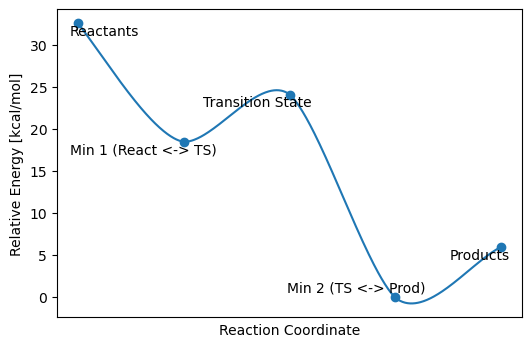

In [22]:
from scipy.interpolate import Rbf
from adjustText import adjust_text

coord = [i for i in range(1, 6)]
conv = psi4.constants.hartree2kcalmol
E0_relative = [(i - np.min(E0_reaction))*conv for i in E0_reaction]

rbf = Rbf(coord, E0_relative, function = 'thin_plate', smooth = 0.001)
x_new = np.linspace(np.min(coord), np.max(coord),500)
y_smooth = rbf(x_new)

plt.figure(figsize=(6, 4))
plt.plot (x_new, y_smooth)
plt.scatter (coord, E0_relative)

texts = [plt.text(coord[i], E0_relative[i], system[i], ha='center', va='center') for i in range(len(coord))]
adjust_text(texts)

plt.xlabel('Reaction Coordinate', fontsize=10)
plt.ylabel('Relative Energy [kcal/mol]', fontsize=10)
plt.tick_params(axis='x', bottom=False, labelbottom=False)

plt.show()

This energetic profile confirms:
- The reaction is exothermic overall.
- The TS lies between two distinct minima, validating it as a true transition state.
- Min 1 and Min 2 are reasonable intermediates corresponding to entrance and exit channels of the TS.

The following table summarizes the geometry parameters (bond lengths and angles) of all the discussed systems:

In [24]:
header = ['System', 'C-Cl [Å]', 'C-F [Å]', 'C-H [Å]', 'Cl-C-H [°]', 'F-C-H [°]']
geometry = [['CH3Cl', 1.786, '-', 1.078, 108.4, '-'],
            ['CH3Cl--F (Min 1)', 1.863, 2.585, 1.070, 106.9, 73.1],
            ['[Cl--CH3--F]- (TS)', 2.135, 2.127, 1.062, 97.2, 82.8],
            ['Cl--CH3F (Min 2)', 3.424, 1.398, 1.077, 71.6, 108.4],
            ['CH3F', '-', 1.371, 1.081, '-', 108.5]]

df = pd.DataFrame(geometry, columns=header)
df

,System,C-Cl [Å],C-F [Å],C-H [Å],Cl-C-H [°],F-C-H [°]
0,CH3Cl,1.786,-,1.078,108.4,-
1,CH3Cl--F (Min 1),1.863,2.585,1.070,106.9,73.1
2,[Cl--CH3--F]- (TS),2.135,2.127,1.062,97.2,82.8
3,Cl--CH3F (Min 2),3.424,1.398,1.077,71.6,108.4
4,CH3F,-,1.371,1.081,-,108.5


### References

[1] Frisch, A.; Foresman, J. B. Exploring Chemistry with Electronic Structure Methods, 3rd ed.; Gaussian, Inc.: Wallingford, CT, 2015.

[2] Marenich, A. V.; Cramer, C. J.; Truhlar, D. G. Intrinsic Reaction Coordinate Approach and Potential Energy Surface Visualization. Proceedings 2019, 41, 81. https://doi.org/10.3390/ecsoc-23-06514.

[3] Chandrasekhar, J.; Smith, S. F.; Jorgensen, W. L. SN2 Reaction Profiles in the Gas Phase and Aqueous Solution. J. Am. Chem. Soc. 1989, 111, 1575–1579.